In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import sqlite3?

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

Object `sqlite3` not found.


In [2]:
ab = '/Users/fairliereese/mortazavi_lab/data/paper_rnawg/figures/data/human/abundance.tsv'
unfilt_ab = '../../lr_bulk/talon/human_talon_abundance.tsv'
filt_ab = '../../lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
talon_filt_ab = '../../lr_bulk/talon/human_talon_abundance_filtered.tsv'
read_annot = '../../lr_bulk/talon/human_talon_read_annot.tsv'
t_metadata = '../../refs/cerberus/v40_transcript_metadata.tsv'
db = '../../lr_bulk/talon/human.db'
ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
swan_file = '../../lr_bulk/cerberus/swan/swan_meta.p'

mouse_unfilt_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance.tsv'  
mouse_talon_filt_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance_filtered.tsv'

## 230424 Some plotting for lab meeting

In [7]:
min_exons = 2

In [6]:
ab_df = pd.read_csv(talon_filt_ab, sep='\t')
df, _ = get_tpm_table(ab_df,
               how='iso',
               nov='all',
               min_tpm=min_tpm)

# merge with extra info
df.reset_index(inplace=True)
df = df.merge(ab_df[['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons']],
              how='left', 
              on='annot_transcript_id')



# n = len(df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic'), 'annot_gene_id'].unique())
# print(f'Found {n} unique intergenic genes w/ >{min_exons} exons and >={min_tpm}')
# n = len(df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic'), 'annot_transcript_id'].unique())
# print(f'Found {n} unique intergenic transcripts w/ >{min_exons} exons and >={min_tpm} tpm')

# df = df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic')]



Calculating iso TPM values
Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Number of isos reported: 175394


In [10]:
# restrict to min exons
df = df.loc[df.n_exons>=min_exons]

# gb gene nov and count how many passed filtering
df = df[['annot_gene_id', 'gene_novelty']].drop_duplicates()

df = df.groupby(['gene_novelty']).count().reset_index()
df.rename({'annot_gene_id': 'n_genes'}, axis=1, inplace=True)

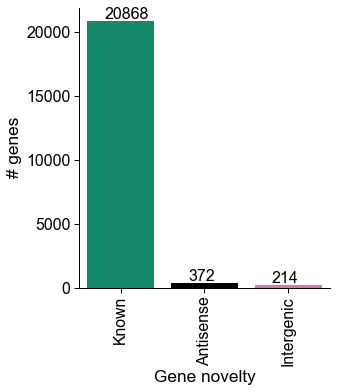

In [19]:
def add_perc(ax, data, feature):
    total = data[feature].sum()
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
#         x = p.get_x() + p.get_width() / 2 - 0.45
        x = p.get_x() + p.get_width() / 2 - (0.065)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.00625
        ax.annotate(percentage, (x, y), size = 12)
        
def add_n(ax, data, feature):
    total = data[feature].sum()
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        numn = f'{int(p.get_height())}'
#         x = p.get_x() + p.get_width() / 2 - 0.45
        x = p.get_x() + p.get_width() / 2 - (0.065)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.00625
        ax.annotate(numn, (x, y), size = 16)
        
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_talon_nov_colors(df.gene_novelty.tolist())


# actual plotting
g = sns.catplot(data=df, x='gene_novelty',
            y='n_genes', kind='bar',
            palette=c_dict, order=order)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.set_ylabels('# genes')
g.set_xlabels('Gene novelty')

# add percentage labels
ax = g.axes[0,0]
add_n(ax, df, 'n_genes')

## Older stuff

In [143]:
ab_df = pd.read_csv(ab, sep='\t')
df, _ = get_tpm_table(ab_df,
                   how='gene',
                   ver=ver,
                   nov='all')

Calculating gene TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2049: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Number of genes reported: 599976


In [144]:
# which novel genes are the most highly expressed? 
df = df.melt(ignore_index=False, var_name='dataset', value_name='tpm').reset_index()

# get rid of 0 exp
df = df.loc[df.tpm>0]

# apply minimum tpm
print(len(df.index))
df = df.loc[df.tpm>=min_tpm]
print(len(df.index))

# merge in novelty info
ab_df['gid_stable'] = cerberus.get_stable_gid(ab_df, col='annot_gene_id')
df = df.merge(ab_df[['gid_stable', 'gene_novelty']], how='left', on='gid_stable')

6403037
3803630


In [132]:
df.sort_values(by='tpm', ascending=False)

,gid_stable,dataset,tpm,gene_novelty
3623298,ENSG00000163631,right_lobe_of_liver_2_1,101559.376250,Known
3262370,ENSG00000087086,right_lobe_of_liver_1_1,86185.005110,Known
3245465,ENSG00000111245,heart_left_ventricle_1_1,76757.529275,Known
1498094,ENSG00000108821,h9_chondro_1_3,73534.925459,Known
3267758,ENSG00000163631,right_lobe_of_liver_1_1,72761.026781,Known
...,...,...,...,...
2897633,ENCODEHG000246041,hl60_m1_72hr_1_1,1.009628,Antisense
2897634,ENCODEHG000246120,hl60_m1_72hr_1_1,1.009628,Intergenic
2897635,ENCODEHG000246221,hl60_m1_72hr_1_1,1.009628,Antisense
2897636,ENCODEHG000246235,hl60_m1_72hr_1_1,1.009628,Intergenic


In [142]:
# # which datasets / samples have the most novel genes expressed?
# temp = df.copy(deep=True)
# temp.drop('tpm', axis=1, inplace=True)
# temp = temp.groupby(['dataset', 'gene_novelty']).count().reset_index()
# temp.rename({'gid_stable': 'n_genes'}, axis=1, inplace=True)

# lib = temp.dataset.unique().tolist()

# b = np.zeros(len(lib))
# for nov in order:
#     temp2 = temp.loc[temp.gene_novelty==nov]
#     h = temp.n_genes.values.tolist()
#     print(np.shape(h))
#     print(np.shape(lib))
#     print(np.shape(
#     p = plt.bar(lib
#                 ,
#                 h,
#                 label=nov,
#                 bottom=b)
#     b += h
    

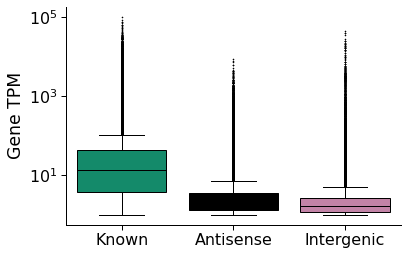

In [48]:
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

c_dict, order = get_talon_nov_colors(df.gene_novelty.tolist())
ax = sns.boxplot(data=df, 
                 y='tpm',
                 x='gene_novelty',
                 palette=c_dict,
                 order=order,
                 linewidth=1,
                 fliersize=1,
                 flierprops={'marker': 'x'})
# ax = sns.violinplot(data=df, 
#                     y='tpm',
#                     x='gene_novelty',
#                     palette=c_dict,
#                     order=order)
ax.set(yscale='log', xlabel='', ylabel='Gene TPM')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

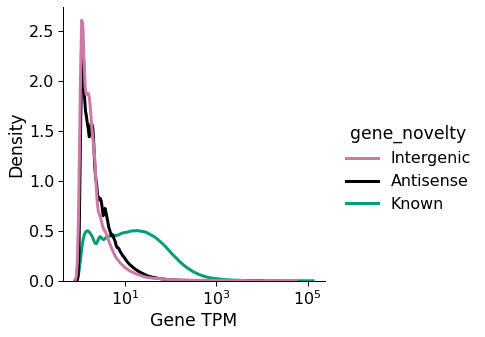

In [49]:
ax = sns.displot(data=df, 
                 x='tpm',
                 kind='kde',
                 hue='gene_novelty',
                 palette=c_dict,
                 linewidth=3,
                 common_norm=False, 
                 log_scale=(True, False))
ax.set(xlabel='Gene TPM')

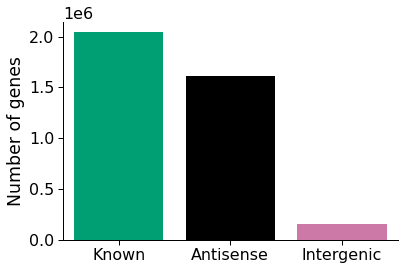

In [62]:
# how many genes of each novelty category are there expressed?
temp = df.copy(deep=True)
temp = temp[['gid_stable', 'gene_novelty']].groupby('gene_novelty').count().reset_index()
temp.rename({'gid_stable': 'n_genes'}, axis=1, inplace=True)
ax = sns.barplot(data=temp, 
                 y='n_genes', 
                 x='gene_novelty',
                 palette=c_dict,
                 order=order,
                 saturation=1)

ax.set(xlabel='', ylabel='Number of genes')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [145]:
# how many isoforms does each gene have by gene novelty

# get all, unfiltered, 1 TPM isoforms
ab_df = pd.read_csv(unfilt_ab, sep='\t')
df, _ = get_tpm_table(ab_df,
                      how='iso',
                      min_tpm=1)

Calculating iso TPM values
Enforcing minimum TPM
Total # isos detected: 5401754
# isos >= 1 tpm: 1669566
Number of isos reported: 1669566


In [77]:
# merge with gene novelty info
df.reset_index(inplace=True)
df = df.merge(ab_df[['annot_transcript_id', 'annot_gene_id', 'gene_novelty']],
              how='left', 
              on='annot_transcript_id')

In [78]:
# how many isos does each gene have?
df = df.groupby(['annot_gene_id', 'gene_novelty']).count().reset_index()
df.rename({'annot_transcript_id': 'n_ts'}, axis=1, inplace=True)

In [80]:
df = df[['annot_gene_id', 'gene_novelty', 'n_ts']]

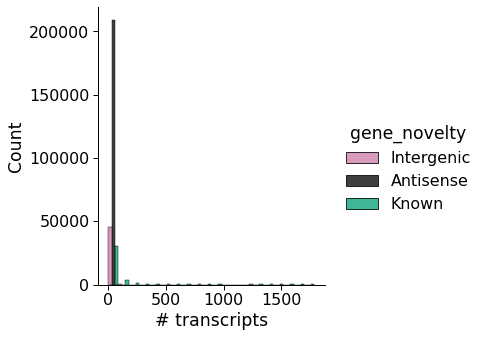

In [90]:
ax = sns.displot(data=df, 
                 kind='hist',
                 x='n_ts',
                 hue='gene_novelty',
                 palette=c_dict,
                 multiple='dodge')
ax.set(xlabel='# transcripts')

In [98]:
# what % of genes have 1 isoform from each category?
temp = df[['annot_gene_id', 'gene_novelty', 'n_ts']].groupby(['n_ts', 'gene_novelty']).count().reset_index()
temp.rename({'annot_gene_id': 'n_genes'}, axis=1, inplace=True)

totals = temp[['gene_novelty', 'n_genes']].groupby('gene_novelty').sum().reset_index()
totals.rename({'n_genes': 'n_total_genes'}, axis=1, inplace=True)

temp = temp.merge(totals, on='gene_novelty')
temp['perc'] = (temp['n_genes']/temp['n_total_genes'])*100
temp.loc[temp.n_ts==1]

,n_ts,gene_novelty,n_genes,n_total_genes,perc
0,1,Antisense,189550,208817,90.773261
57,1,Intergenic,41893,45219,92.644685
106,1,Known,8602,35537,24.205757


In [181]:
# how many exons do isoforms of genes of different
# novelty types have?

# get all, unfiltered, 1 TPM isoforms
ab_df = pd.read_csv(talon_filt_ab, sep='\t')
df, _ = get_tpm_table(ab_df,
                      how='iso',
                      min_tpm=1)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2049: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Number of isos reported: 175394


In [182]:
# merge with extra info
df.reset_index(inplace=True)
df = df.merge(ab_df[['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons']],
              how='left', 
              on='annot_transcript_id')

In [183]:
n = len(df.loc[(df.n_exons>1)&(df.gene_novelty=='Intergenic'), 'annot_gene_id'].unique())
print(n)
n = len(df.loc[(df.n_exons>1)&(df.gene_novelty=='Intergenic'), 'annot_transcript_id'].unique())
print(n)


214
412


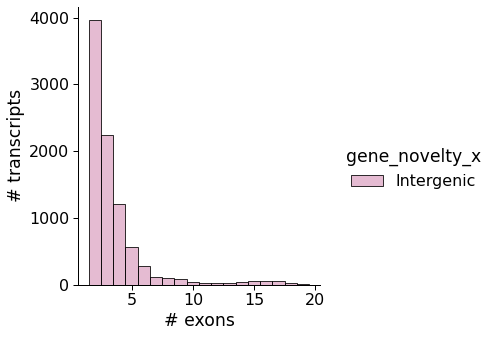

In [175]:
# temp4 = temp.loc[temp.gene_novelty_x=='Intergenic']
temp5 = temp4.loc[temp4.n_exons_x > 1]
ax = sns.displot(data=temp5, 
                 kind='hist',
                 x='n_exons_x',
                 hue='gene_novelty_x',
                 palette=c_dict,
                 discrete=True,
                 binwidth=1)
ax.set(xlabel='# exons', ylabel='# transcripts')

In [164]:
temp4.loc[temp4.n_exons_x
          ==1]

,annot_transcript_id,annot_gene_id_x,n_exons_x,gene_novelty_x
71993,ENCODEHT000206762,ENCODEHG000058781,1,Intergenic
71994,ENCODEHT000206763,ENCODEHG000058782,1,Intergenic
71995,ENCODEHT000206764,ENCODEHG000058783,1,Intergenic
71997,ENCODEHT000206766,ENCODEHG000058785,1,Intergenic
71998,ENCODEHT000206767,ENCODEHG000058786,1,Intergenic
...,...,...,...,...
1669270,ENCODEHT005507770,ENCODEHG000613876,1,Intergenic
1669283,ENCODEHT005507894,ENCODEHG000613915,1,Intergenic
1669407,ENCODEHT005509868,ENCODEHG000614148,1,Intergenic
1669531,ENCODEHT005511279,ENCODEHG000614458,1,Intergenic


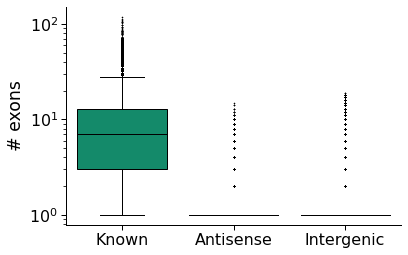

In [113]:
ax = sns.boxplot(data=df, 
                 y='n_exons',
                 x='gene_novelty',
                 palette=c_dict,
                 order=order,
                 linewidth=1,
                 fliersize=1,
                 flierprops={'marker': 'x'})
ax.set(yscale='log', xlabel='', ylabel='# exons')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

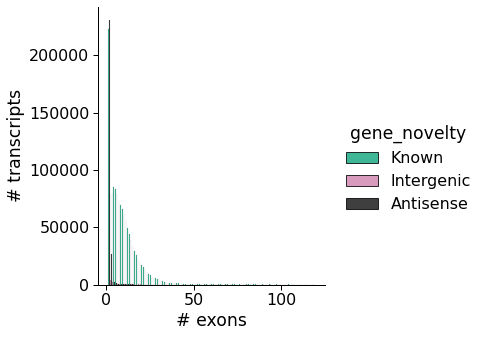

In [123]:
ax = sns.displot(data=df, 
                 kind='hist',
                 x='n_exons',
                 hue='gene_novelty',
                 palette=c_dict,
                 multiple='dodge',
                 binwidth=1)
ax.set(xlabel='# exons', ylabel='# transcripts')

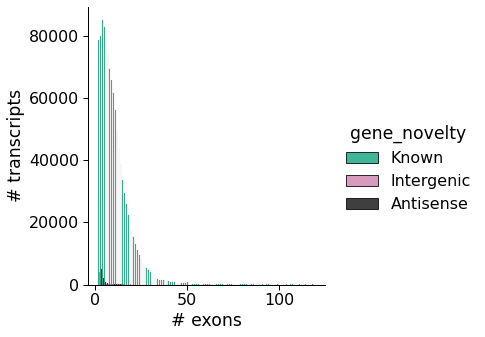

In [122]:
# what about when we remove monoexonic transcripts?
temp2 = temp.loc[temp.n_exons>1]
ax = sns.displot(data=temp2, 
                 kind='hist',
                 x='n_exons',
                 hue='gene_novelty',
                 palette=c_dict,
                 multiple='dodge',
                 binwidth=1)
ax.set(xlabel='# exons', ylabel='# transcripts')

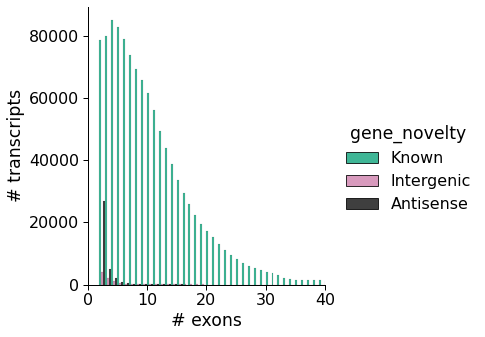

In [124]:
# what about when we remove monoexonic transcripts?
temp2 = temp.loc[temp.n_exons>1]
ax = sns.displot(data=temp2, 
                 kind='hist',
                 x='n_exons',
                 hue='gene_novelty',
                 palette=c_dict,
                 multiple='dodge',
                 binwidth=1)
ax.set(xlabel='# exons', ylabel='# transcripts',
       xlim=(0,40))

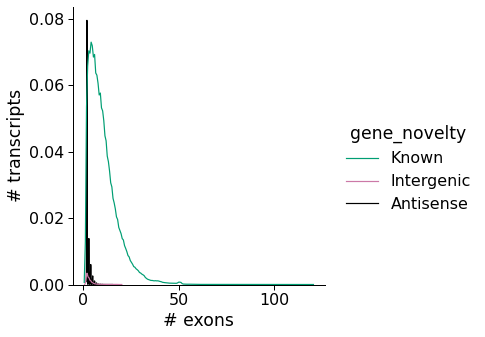

In [129]:
ax = sns.displot(data=temp2, 
                 kind='kde',
                 x='n_exons',
                 hue='gene_novelty',
                 palette=c_dict, 
                 common_norm=True)
ax.set(xlabel='# exons', ylabel='# transcripts')

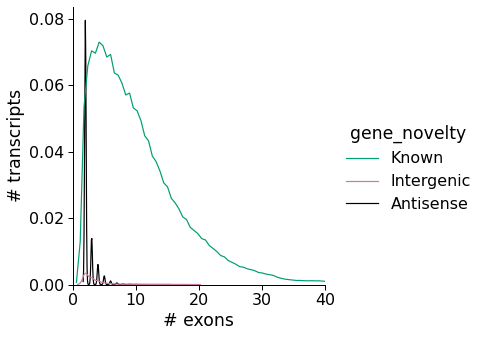

In [128]:
ax = sns.displot(data=temp2, 
                 kind='kde',
                 x='n_exons',
                 hue='gene_novelty',
                 palette=c_dict, 
                 common_norm=True)
ax.set(xlabel='# exons', ylabel='# transcripts',
       xlim=(0,40))

## Novel transcript filter

In [29]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import sqlite3

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

ab = '/Users/fairliereese/mortazavi_lab/data/paper_rnawg/figures/data/human/abundance.tsv'
unfilt_ab = '../../lr_bulk/talon/human_talon_abundance.tsv'
filt_ab = '../../lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
talon_filt_ab = '../../lr_bulk/talon/human_talon_abundance_filtered.tsv'
read_annot = '../../lr_bulk/talon/human_talon_read_annot.tsv'
t_metadata = '../../refs/cerberus/v40_transcript_metadata.tsv'
db = '../../lr_bulk/talon/human.db'
ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
swan_file = '../../lr_bulk/cerberus/swan/swan_meta.p'

mouse_unfilt_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance.tsv'  
mouse_talon_filt_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance_filtered.tsv'

In [34]:
def get_n_intergenic_t_g(ab_file,
                         min_tpm,
                         min_exons,
                         **kwargs):
    ab_df = pd.read_csv(ab_file, sep='\t')
    df, _ = get_tpm_table(ab_df,
                   how='iso',
                   nov='all',
                   min_tpm=min_tpm,
                   **kwargs)
    
    # merge with extra info
    df.reset_index(inplace=True)
    df = df.merge(ab_df[['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons']],
                  how='left', 
                  on='annot_transcript_id')
    
    n = len(df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic'), 'annot_gene_id'].unique())
    print(f'Found {n} unique intergenic genes w/ >{min_exons} exons and >={min_tpm}')
    n = len(df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic'), 'annot_transcript_id'].unique())
    print(f'Found {n} unique intergenic transcripts w/ >{min_exons} exons and >={min_tpm} tpm')
    
    df = df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic')]
    
    return df

In [98]:
# filtered talon abundance file
# should be filtered for 5 reads in 2 datasets
# and have the internal priming filter
df = get_n_intergenic_t_g(talon_filt_ab, 
                     min_tpm=1,
                     min_exons=2)
tids_2 = df.annot_transcript_id.tolist()

Calculating iso TPM values
Number of isos reported: 194503
Found 214 unique intergenic genes w/ >2 exons and >=0
Found 412 unique intergenic transcripts w/ >2 exons and >=0 tpm


In [4]:
# unfiltered talon abundance file
get_n_intergenic_t_g(unfilt_ab, 
                     min_tpm=1,
                     min_exons=2)

Calculating iso TPM values
Enforcing minimum TPM
Total # isos detected: 5401754
# isos >= 1 tpm: 1669566
Number of isos reported: 1669566
Found 3705 unique intergenic genes w/ >2 exons and >=1
Found 8829 unique intergenic transcripts w/ >2 exons and >=1


In [97]:
# ab_df = pd.read_csv(talon_filt_ab, sep='\t')
# df, _ = get_tpm_table(ab_df,
#                    how='iso',
#                    nov='all',
#                    min_tpm=1)

In [41]:
# ensure that, idk, the talon filter actually worked cause that is a rly steep drop
min_reads = 5
min_datasets = 2
min_exons = 2
ab_df = pd.read_csv(unfilt_ab, sep='\t')

In [83]:
# ensure novelty type
print(f'Total number of unfilt. isos {len(ab_df.index)}')
df = ab_df.copy(deep=True)
df = df.loc[df.gene_novelty=='Intergenic']
print(f'Number of intergenic isos {len(df.index)}')

Total number of unfilt. isos 5401754
Number of intergenic isos 205201


In [84]:
# ensure min exons
df = df.loc[df.n_exons >= min_exons]
print(f'Number of intergenic isos w/ >={min_exons} exons {len(df.index)}')

Number of intergenic isos w/ >=2 exons 42053


In [85]:
cols = get_dataset_cols()
df.set_index('annot_transcript_id', inplace=True)
df = df[cols]

In [86]:
# df.loc[df['aorta_2_1']>=min_reads].head()
df.loc['ENCODEHT000206833']

mcf7_1_1                     9
k562_1_1                     3
heart_right_ventricle_2_1    4
gm12878_3_1                  9
heart_right_ventricle_3_1    7
                            ..
pgp1_endo_1_2                0
left_cardiac_atrium_1_1      0
h9_neural_crest_1_1          0
h9_neural_crest_1_2          0
left_lung_2_1                0
Name: ENCODEHT000206833, Length: 138, dtype: int64

In [87]:
df = df >= min_reads
# df.loc[df['aorta_2_1'] == True].head()
df.loc['ENCODEHT000206833']

mcf7_1_1                      True
k562_1_1                     False
heart_right_ventricle_2_1    False
gm12878_3_1                   True
heart_right_ventricle_3_1     True
                             ...  
pgp1_endo_1_2                False
left_cardiac_atrium_1_1      False
h9_neural_crest_1_1          False
h9_neural_crest_1_2          False
left_lung_2_1                False
Name: ENCODEHT000206833, Length: 138, dtype: bool

In [88]:
df = df.loc[df.sum(axis=1)>=min_datasets]
print(f'Number of intergenic isos w/ >={min_exons} exons and >={min_reads} reads in >={min_datasets} datasets {len(df.index)}')

Number of intergenic isos w/ >=2 exons and >=5 reads in >=2 datasets 432


In [89]:
df.head()

,mcf7_1_1,k562_1_1,heart_right_ventricle_2_1,gm12878_3_1,heart_right_ventricle_3_1,pc3_1_1,lower_lobe_of_right_lung_1_1,hl60_m1_24hr_1_1,hl60_m1_24hr_1_2,hl60_m2_24hr_1_1,...,heart_right_ventricle_1_1,right_lobe_of_liver_2_1,hl60_1_1,hl60_1_2,pgp1_endo_1_1,pgp1_endo_1_2,left_cardiac_atrium_1_1,h9_neural_crest_1_1,h9_neural_crest_1_2,left_lung_2_1
annot_transcript_id,,,,,,,,,,,,,,,,,,,,,
ENCODEHT000206765,True,True,True,True,True,False,False,False,False,False,...,True,False,True,False,False,False,True,True,True,False
ENCODEHT000206785,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,True,False
ENCODEHT000206825,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ENCODEHT000206831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ENCODEHT000206833,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [90]:
tids_1 = df.index.tolist()

In [96]:
len(set(tids_1)&(set(tids_2)))

340

In [99]:
# ensure that, idk, the talon filter actually worked cause that is a rly steep drop
# try this again but this time from the database
query = """SELECT * FROM abundance"""
with sqlite3.connect(db) as conn: 
    df = pd.read_sql_query(query, conn)


In [100]:
ab_df = pd.read_csv(unfilt_ab, sep='\t')

In [103]:
df = df.merge(ab_df[['transcript_ID', 'annot_transcript_id', 'n_exons', 'gene_novelty']],
              on='transcript_ID', how='left')

In [104]:
df.head()

,transcript_ID,dataset,count,annot_transcript_id,n_exons,gene_novelty
0,206762,gm12878_3_1,1,ENCODEHT000206762,1,Intergenic
1,206763,gm12878_3_1,10,ENCODEHT000206763,1,Intergenic
2,206767,gm12878_3_1,4,ENCODEHT000206767,1,Intergenic
3,206765,gm12878_3_1,11,ENCODEHT000206765,11,Intergenic
4,206770,gm12878_3_1,2,ENCODEHT000206770,9,Intergenic


In [105]:
# remove non-intergenic
print(f'Total number of unfilt. isos {len(df.annot_transcript_id.unique())}')
df = df.loc[df.gene_novelty=='Intergenic']
print(f'Total number of intergenic isos {len(df.annot_transcript_id.unique())}')

Total number of unfilt. isos 5401754
Total number of intergenic isos 205201


In [106]:
# ensure min exons
df = df.loc[df.n_exons >= min_exons]
print(f'Number of intergenic isos w/ >={min_exons} exons {len(df.annot_transcript_id.unique())}')

Number of intergenic isos w/ >=2 exons 42053


In [110]:
# ensure min reads / min datasets
df['min_reads'] = df['count'] >= min_reads
df.head()

,transcript_ID,dataset,count,annot_transcript_id,n_exons,gene_novelty,min_reads
3,206765,gm12878_3_1,11,ENCODEHT000206765,11,Intergenic,True
4,206770,gm12878_3_1,2,ENCODEHT000206770,9,Intergenic,False
8,206778,gm12878_3_1,1,ENCODEHT000206778,2,Intergenic,False
9,206785,gm12878_3_1,3,ENCODEHT000206785,11,Intergenic,False
26,206820,gm12878_3_1,1,ENCODEHT000206820,8,Intergenic,False


In [126]:
# count up number of datasets that min_reads is good in
temp = df[['transcript_ID', 'annot_transcript_id',
           'dataset', 'min_reads']].groupby(by=['transcript_ID', 
                                                'annot_transcript_id', 
                                                'min_reads']).count().reset_index()
temp.rename({'dataset': 'n_datasets'}, axis=1, inplace=True)

In [127]:
len(df.loc[(df.transcript_ID==206765)&(df.min_reads==True)])

42

In [128]:
temp.loc[(temp.transcript_ID==206765)&(temp.min_reads==True)]

,transcript_ID,annot_transcript_id,min_reads,n_datasets
1,206765,ENCODEHT000206765,True,42


In [129]:
# restrict to the isoforms that meet min reads / min datasets
temp = temp.loc[(temp.min_reads==True)&(temp.n_datasets>=min_datasets)]

In [130]:
print(f'Number of intergenic isos w/ >={min_exons} exons and >={min_reads} reads in >={min_datasets} datasets {len(temp.annot_transcript_id.unique())}')

Number of intergenic isos w/ >=2 exons and >=5 reads in >=2 datasets 542


In [131]:
tids_3 = temp.annot_transcript_id.unique().tolist()

In [132]:
len(set(tids_3)&(set(tids_2)))

412

In [30]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import sqlite3

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

ab = '/Users/fairliereese/mortazavi_lab/data/paper_rnawg/figures/data/human/abundance.tsv'
unfilt_ab = '../../lr_bulk/talon/human_talon_abundance.tsv'
filt_ab = '../../lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
talon_filt_ab = '../../lr_bulk/talon/human_talon_abundance_filtered.tsv'
read_annot = '../../lr_bulk/talon/human_talon_read_annot.tsv'
t_metadata = '../../refs/cerberus/v40_transcript_metadata.tsv'
db = '../../lr_bulk/talon/human.db'
ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
swan_file = '../../lr_bulk/cerberus/swan/swan_meta.p'

mouse_unfilt_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance.tsv'  
mouse_talon_filt_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance_filtered.tsv'

In [33]:
# def get_n_intergenic_t_g(ab_file,
#                          min_tpm,
#                          min_exons,
#                          **kwargs):
#     ab_df = pd.read_csv(ab_file, sep='\t')
#     df, _ = get_tpm_table(ab_df,
#                    how='iso',
#                    nov='all',
#                    min_tpm=min_tpm)
    
#     # merge with extra info
#     df.reset_index(inplace=True)
#     df = df.merge(ab_df[['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons']],
#                   how='left', 
#                   on='annot_transcript_id')
    
#     n = len(df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic'), 'annot_gene_id'].unique())
#     print(f'Found {n} unique intergenic genes w/ >{min_exons} exons and >={min_tpm}')
#     n = len(df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic'), 'annot_transcript_id'].unique())
#     print(f'Found {n} unique intergenic transcripts w/ >{min_exons} exons and >={min_tpm} tpm')
    
#     df = df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic')]
    
#     return df

## How many exons does each isoform that passes this filtering have?

In [4]:
df = get_n_intergenic_t_g(talon_filt_ab, 
                     min_tpm=1,
                     min_exons=2)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2051: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2052: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Number of isos reported: 175394
Found 214 unique intergenic genes w/ >2 exons and >=1
Found 412 unique intergenic transcripts w/ >2 exons and >=1 tpm


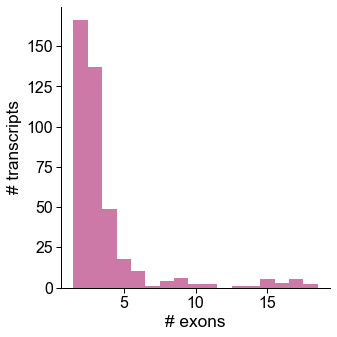

In [142]:
c_dict, order = get_talon_nov_colors()
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ax = sns.displot(data=df, 
                 kind='hist',
                 x='n_exons',
                 color=c_dict['Intergenic'],
                 discrete=True,
                 binwidth=1,
                 alpha=1,
                 linewidth=0)
ax.set(xlabel='# exons', ylabel='# transcripts')

## How many isoforms does each intergenic gene have?

In [144]:
temp = df[['annot_transcript_id', 'annot_gene_id']].groupby('annot_gene_id').count().reset_index()
temp.rename({'annot_transcript_id': 'n_transcripts'}, axis=1, inplace=True)

In [184]:
# temp

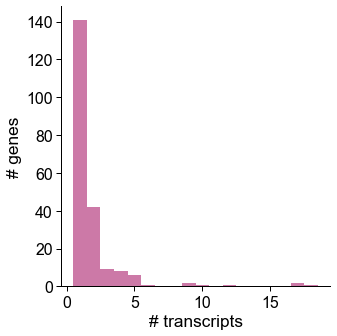

In [146]:
ax = sns.displot(data=temp, 
                 kind='hist',
                 x='n_transcripts',
                 color=c_dict['Intergenic'],
                 discrete=True,
                 binwidth=1,
                 alpha=1,
                 linewidth=0)
ax.set(xlabel='# transcripts', ylabel='# genes')

## How much expression derives from intergenic isoforms per library? 

In [26]:
def plot_intergenic_t_tpm_vs_n(ab_file,
                               **kwargs):
    
    df = get_n_intergenic_t_g(talon_filt_ab, **kwargs)
    temp = df.drop(['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons'], axis=1)
    temp = temp.sum(axis=0).to_frame().reset_index().rename({0:'intergenic_tpm', 'index':'dataset'}, axis=1)
    temp2 = df.drop(['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons'], axis=1)
    temp2 = temp2 > 0 # this can be changed to a min tpm, try this first though
    temp2 = temp2.sum(axis=0).to_frame().reset_index().rename({0:'n_intergenic_isos', 'index':'dataset'}, axis=1)
    temp = temp.merge(temp2, on='dataset')
    # add sample information
    meta = pd.read_csv('/Users/fairliereese/mortazavi_lab/data/rnawg/lr_bulk/lr_human_library_data_summary.tsv', sep='\t')
    meta = meta[['dataset', 'sample']]
    temp = temp.merge(meta, on='dataset')
    
    sns.set_context('paper', font_scale=1.8)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    c_dict, order = get_biosample_colors()
    ax = sns.scatterplot(data=temp,
                    x='n_intergenic_isos',
                    y='intergenic_tpm',
                    hue='sample',
                    palette=c_dict)
    ax.set(yscale='log', xlabel='# expressed intergenic transcripts', ylabel='TPM from intergenic transcripts')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_legend().remove()


    
    

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2051: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2052: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Number of isos reported: 175394
Found 214 unique intergenic genes w/ >2 exons and >=1
Found 412 unique intergenic transcripts w/ >2 exons and >=1 tpm


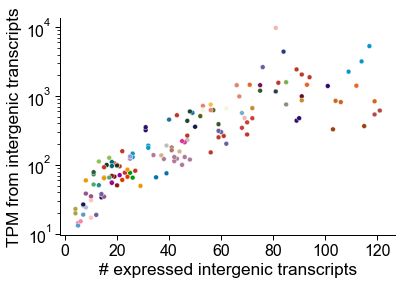

In [27]:
plot_intergenic_t_tpm_vs_n(talon_filt_ab,
                           min_tpm=1,
                           min_exons=2)

In [ ]:
## temp = df.drop(['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons'], axis=1)
temp = temp.sum(axis=0).to_frame().reset_index().rename({0:'intergenic_tpm', 'index':'dataset'}, axis=1)
# temp

In [180]:
temp2 = df.drop(['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons'], axis=1)
temp2 = temp2 > 0 # this can be changed to a min tpm, try this first though
temp2 = temp2.sum(axis=0).to_frame().reset_index().rename({0:'n_intergenic_isos', 'index':'dataset'}, axis=1)
# temp2

In [181]:
print(len(temp.index))
temp = temp.merge(temp2, on='dataset')
print(len(temp.index))

138
138


In [182]:
# add sample information
meta = pd.read_csv('/Users/fairliereese/mortazavi_lab/data/rnawg/lr_bulk/lr_human_library_data_summary.tsv', sep='\t')
meta = meta[['dataset', 'sample']]
temp = temp.merge(meta, on='dataset')

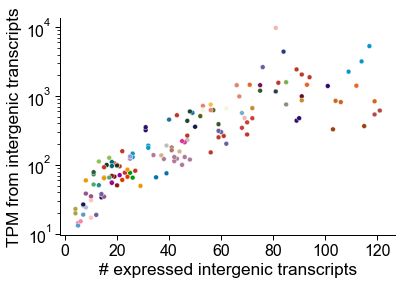

In [183]:
c_dict, order = get_biosample_colors()
ax = sns.scatterplot(data=temp,
                x='n_intergenic_isos',
                y='intergenic_tpm',
                hue='sample',
                palette=c_dict)
ax.set(yscale='log', xlabel='# expressed intergenic transcripts', ylabel='TPM from intergenic transcripts')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()

## How much gene expression derives from intergenic genes that passed our filters?

In [5]:
# get the IDs of the genes that passed the filtering
df = get_n_intergenic_t_g(talon_filt_ab, 
                     min_tpm=1,
                     min_exons=2)

Calculating iso TPM values
Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Number of isos reported: 175394
Found 214 unique intergenic genes w/ >2 exons and >=1
Found 412 unique intergenic transcripts w/ >2 exons and >=1 tpm


In [7]:
# get the TPMs of all genes
ab_df = pd.read_csv(unfilt_ab, sep='\t')
gene_df, _ = get_tpm_table(ab_df,
                           how='gene',
                           nov='all',
                           min_tpm=1)

Calculating gene TPM values
Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Number of genes reported: 292060


In [11]:
gids = df.annot_gene_id.unique().tolist()
gene_df.head()

In [17]:
# total TPM from filtered intergenic genes
temp = gene_df.loc[gids]
print(len(temp.index))
temp = temp.reset_index(drop=True)
temp = temp.sum(axis=0).to_frame().reset_index().rename({0:'intergenic_tpm', 'index':'dataset'}, axis=1)

214


In [21]:
temp2 = gene_df.loc[gids]
print(len(temp2.index))
temp2 = temp2.reset_index(drop=True)
temp2 = temp2 > 0 # this can be changed to a min tpm, try this first though
temp2 = temp2.sum(axis=0).to_frame().reset_index().rename({0:'n_intergenic_genes', 'index':'dataset'}, axis=1)

214


In [22]:
print(len(temp.index))
temp = temp.merge(temp2, on='dataset')
print(len(temp.index))

138
138


In [23]:
# add sample information
meta = pd.read_csv('/Users/fairliereese/mortazavi_lab/data/rnawg/lr_bulk/lr_human_library_data_summary.tsv', sep='\t')
meta = meta[['dataset', 'sample']]
temp = temp.merge(meta, on='dataset')

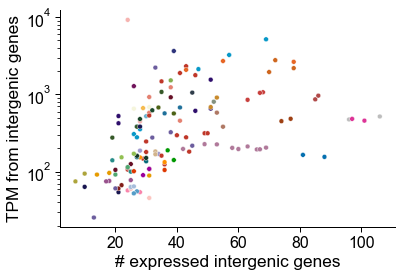

In [25]:
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

c_dict, order = get_biosample_colors()
ax = sns.scatterplot(data=temp,
                x='n_intergenic_genes',
                y='intergenic_tpm',
                hue='sample',
                palette=c_dict)
ax.set(yscale='log', xlabel='# expressed intergenic genes', ylabel='TPM from intergenic genes')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()

## What about mouse?

In [35]:
df = get_n_intergenic_t_g(mouse_talon_filt_ab, 
                          min_tpm=1,
                          min_exons=2,
                          species='mouse')

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2051: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2052: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 122685
# isos >= 1 tpm: 114790
Number of isos reported: 114790
Found 96 unique intergenic genes w/ >2 exons and >=1
Found 175 unique intergenic transcripts w/ >2 exons and >=1 tpm


## Number of genes w/ a detected spliced isoform; by novelty (known=polyA only) and species

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import sqlite3

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

ab = '/Users/fairliereese/mortazavi_lab/data/paper_rnawg/figures/data/human/abundance.tsv'
unfilt_ab = '../../lr_bulk/talon/human_talon_abundance.tsv'
filt_ab = '../../lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
talon_filt_ab = '../../lr_bulk/talon/human_talon_abundance_filtered.tsv'
read_annot = '../../lr_bulk/talon/human_talon_read_annot.tsv'
t_metadata = '../../refs/cerberus/v40_transcript_metadata.tsv'
db = '../../lr_bulk/talon/human.db'
ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
swan_file = '../../lr_bulk/cerberus/swan/swan_meta.p'

mouse_unfilt_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance.tsv'  
mouse_talon_filt_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance_filtered.tsv'

In [48]:
def get_n_intergenic_t_g(ab_file,
                         min_tpm,
                         min_exons,
                         **kwargs):
    ab_df = pd.read_csv(ab_file, sep='\t')
    df, _ = get_tpm_table(ab_df,
                   how='iso',
                   nov='all',
                   min_tpm=min_tpm,
                   **kwargs)
    
    # merge with extra info
    df.reset_index(inplace=True)
    df = df.merge(ab_df[['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons']],
                  how='left', 
                  on='annot_transcript_id')
    
    n = len(df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic'), 'annot_gene_id'].unique())
    print(f'Found {n} unique intergenic genes w/ >{min_exons} exons and >={min_tpm}')
    n = len(df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic'), 'annot_transcript_id'].unique())
    print(f'Found {n} unique intergenic transcripts w/ >{min_exons} exons and >={min_tpm} tpm')
    
    df = df.loc[(df.n_exons>=min_exons)&(df.gene_novelty=='Intergenic')]
    
    return df

In [43]:
min_exons = 2
min_tpm = 1

In [60]:
# human known
ab_df = pd.read_csv(talon_filt_ab, sep='\t')
df, _ = get_tpm_table(ab_df,
                      how='iso',
                      gene_subset='polya',
                      min_tpm=min_tpm)
# merge with extra info
df.reset_index(inplace=True)
df = df.merge(ab_df[['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons']],
              how='left', 
              on='annot_transcript_id')

print(len(df.index))
df = df.loc[df.n_exons>=min_exons] 
print(len(df.index))
n_human_known = len(df.annot_gene_id.unique())
print(n_human_known)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 159345
159345
149134
20716


In [61]:
# human intergenic
df = get_n_intergenic_t_g(talon_filt_ab,
                          min_tpm,
                          min_exons)
n_human_novel = len(df.annot_gene_id.unique())
print(n_human_novel)

Calculating iso TPM values
Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Number of isos reported: 175394
Found 214 unique intergenic genes w/ >2 exons and >=1
Found 412 unique intergenic transcripts w/ >2 exons and >=1 tpm
214


In [62]:
# mouse known
ab_df = pd.read_csv(mouse_talon_filt_ab, sep='\t')
df, _ = get_tpm_table(ab_df,
                      how='iso',
                      gene_subset='polya',
                      min_tpm=min_tpm,
                      species='mouse')
# merge with extra info
df.reset_index(inplace=True)
df = df.merge(ab_df[['annot_transcript_id', 'annot_gene_id', 'gene_novelty', 'n_exons']],
              how='left', 
              on='annot_transcript_id')

print(len(df.index))
df = df.loc[df.n_exons>=min_exons] 
print(len(df.index))
n_mouse_known = len(df.annot_gene_id.unique())
print(n_mouse_known)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 122685
# isos >= 1 tpm: 114790
Applying gene type and novelty subset
Number of isos reported: 108867
108867
100220
18971


In [63]:
# mouse intergenic
df = get_n_intergenic_t_g(mouse_talon_filt_ab,
                          min_tpm,
                          min_exons,
                          species='mouse')
n_mouse_novel = len(df.annot_gene_id.unique())
print(n_mouse_novel)

Calculating iso TPM values
Enforcing minimum TPM
Total # isos detected: 122685
# isos >= 1 tpm: 114790
Number of isos reported: 114790
Found 96 unique intergenic genes w/ >2 exons and >=1
Found 175 unique intergenic transcripts w/ >2 exons and >=1 tpm
96


In [95]:
df = pd.DataFrame([[n_human_known, n_human_novel],
                   [n_mouse_known, n_mouse_novel]], 
                  columns=['Known', 'Intergenic'],
                  index=['Human', 'Mouse'])
                  

In [96]:
df

,Known,Intergenic
Human,20716,214
Mouse,18971,96


In [97]:
df['total'] = df.sum(axis=1)
df['perc'] = (df['Intergenic']/df['total'])*100
df

,Known,Intergenic,total,perc
Human,20716,214,20930,1.022456
Mouse,18971,96,19067,0.503488


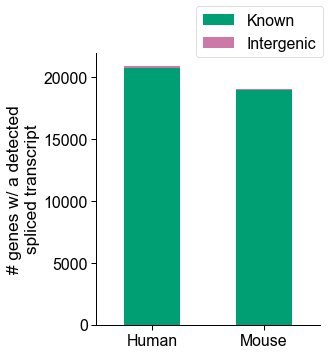

In [90]:

c_dict, order = get_talon_nov_colors(df.columns.tolist())
ax = df.plot.bar(stacked=True, 
                 color=c_dict,
                 figsize=(4,5))
ax.set(ylabel='# genes w/ a detected\nspliced transcript')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis="x", rotation=0)
# ax.get_legend().remove()
plt.legend(bbox_to_anchor=(1.05,1.2),
           loc='upper right')